In [114]:
from nilearn.datasets import MNI152_FILE_PATH
import pandas as pd
from nilearn import image, glm, plotting, input_data

import numpy as np

from nilearn.input_data import NiftiMasker
import nibabel as nib

from brainiak.searchlight.searchlight import Searchlight, Ball

import time
import os
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask
import pdb

from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [159]:
study ='docnet'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/fc'
results_dir = '/user_data/vayzenbe/GitHub_Repos/docnet/results'
exp = 'catmvpa'
subj_list=["docnet2001", "docnet2003","docnet2004", "docnet2005", "docnet2007","docnet2008", "docnet2012"]
subj_list = [2001,2003,2004, 2005, 2008, 2012]
#subj_list = [2008, 2012]

#lr = 'r'
#rr = 'PPC_spaceloc'
runs = list(range(1,9))
#runs = list(range(1,5))


vols = 331
first_fix = 8

pc_thresh = .9
clf = Ridge(normalize=True) #how to best to choose regularization term?
clf = LinearRegression()
#train/test split in 6 and 2 runs
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)


In [145]:
def extract_pc(data, n_components=None):

    """
    Extract principal components
    if n_components isn't set, it will extract all it can
    """
    pca = PCA(n_components = n_components)
    pca.fit(data)
    
    return pca

In [146]:
def calc_pc_n(pca, thresh):
    '''
    Calculate how many PCs are needed to explain X% of data
    
    pca - result of pca analysis
    thresh- threshold for how many components to keep
    '''

    explained_variance = pca.explained_variance_ratio_
    
    var = 0
    for n_comp, ev in enumerate(explained_variance):
        var += ev #add each PC's variance to current variance
        #print(n_comp, ev, var)

        if var >=thresh: #once variance > than thresh, stop
            break
    
    '''
    plt.bar(range(len(explained_variance[0:n_comp+1])), explained_variance[0:n_comp+1], alpha=0.5, align='center')
    plt.ylabel('Variance ratio')
    plt.xlabel('Principal components')
    plt.show()
    '''
    return n_comp+1

In [147]:
def extract_roi_sphere(img, coords):
    roi_masker = input_data.NiftiSpheresMasker([tuple(coords)], radius = 6)
    seed_time_series = roi_masker.fit_transform(img)
    
    phys = np.mean(seed_time_series, axis= 1)
    phys = (phys - np.mean(phys)) / np.std(phys) #TRY WITHOUT STANDARDIZING AT SOME POINT
    phys = phys.reshape((phys.shape[0],1))
    
    return phys

In [155]:
def extract_rois(run, rois, img):
    all_rois = pd.DataFrame(columns = ['run','roi','ts'])
    roi_data = []
    for lr in ['l','r']:
        for rr in rois:
            if os.path.exists(f'{roi_dir}/{lr}{rr}.nii.gz'):
                #print(f'{lr}{rr}')
                roi = image.get_data(image.load_img(f'{roi_dir}/{lr}{rr}_peak.nii.gz'))
                reshaped_roi = np.reshape(roi, (91,109,91,1))
                masked_img = reshaped_roi*curr_run

                #extract voxel resposnes from within mask
                vox_acts = masked_img.reshape(-1, vols) #reshape into rows (voxels) x columns (time)
                vox_acts =vox_acts[~np.all(vox_acts == 0, axis=1)] #remove voxels that are 0 (masked out)
                vox_acts = np.transpose(vox_acts)
                vox_acts = vox_acts[first_fix:, :] #remove first 8 vols
                roi_data.append([run, f'{lr}{rr}', vox_acts])

                
    roi_data = np.array(roi_data)
    all_rois = all_rois.append(pd.DataFrame(roi_data, columns=all_rois.columns), ignore_index=True)

    return all_rois

            
            

In [156]:
def calc_mvc(seed_train,seed_test, target_train, target_test, target_pc):
    """
    Conduct ridge by iteratively fitting all seed PCs to target PCs

    seed_train,seed_test, target_train, target_test, target_pc
    """

    all_corrs = []
    for pcn in range(0,len(target_pc.explained_variance_ratio_)):
        
        clf.fit(seed_train, target_train[:,pcn]) #fit seed PCs to target
        pred_ts = clf.predict(seed_test) #use dorsal test data to predict left out runs of ventral test data
        weighted_corr = np.corrcoef(pred_ts,target_test[:,pcn])[0,1] * target_pc.explained_variance_ratio_[pcn]
        all_corrs.append(weighted_corr)

    final_corr = np.sum(all_corrs)/(np.sum(target_pc.explained_variance_ratio_))

    return final_corr

In [157]:
def shuffle_split(all_rois):
    #create summary file
    roi_summary= pd.DataFrame(columns = ['ventral_roi', 'dorsal_roi', 'mvc'])


    for lr in ['l','r']:
        for vr in ventral_rois:
            vroi = f'{lr}{vr}'
            if os.path.exists(f'{roi_dir}/{vroi}_peak.nii.gz'):
                ventral_df =all_rois[(all_rois['roi'] == vroi)].reset_index()


                for lr in ['r']:
                    for dr in dorsal_rois:
                        droi = f'{lr}{dr}'
                        if os.path.exists(f'{roi_dir}/{droi}_peak.nii.gz'):
                            dorsal_df =all_rois[(all_rois['roi'] == droi)].reset_index()
                            print(vroi,droi)

                            mvc_list = []
                            for train_index, test_index in rs.split(runs): #extract data for each split
                                #create train and test set for ventral regions
                                ventral_train = np.concatenate(ventral_df['ts'].iloc[train_index].to_numpy())
                                ventral_test= np.concatenate(ventral_df['ts'].iloc[test_index].to_numpy())

                                #extract PCs from ventral regions
                                n_comp = calc_pc_n(extract_pc(ventral_train),pc_thresh) #determine number of PCs in train_data using threshold
                                v_pca = extract_pc(ventral_train, n_comp) #conduct PCA one more time with that number of PCs

                                vtrain_pcs = v_pca.transform(ventral_train) #transform train data in PCs
                                vtest_pcs = v_pca.transform(ventral_test) #transform test data into PCs
                                    
                                
                                #create train and test set for dorsal regions
                                dorsal_train = np.concatenate(dorsal_df['ts'].iloc[train_index].to_numpy())
                                dorsal_test = np.concatenate(dorsal_df['ts'].iloc[test_index].to_numpy())

                                #extract PC from dorsal region
                                n_comp = calc_pc_n(extract_pc(dorsal_train),pc_thresh) #determine number of PCs in train_data using threshold
                                d_pca = extract_pc(dorsal_train, n_comp) #conduct PCA one more time with that number of PCs

                                dtrain_pcs = d_pca.transform(dorsal_train) #transform train data in PCs
                                dtest_pcs = d_pca.transform(dorsal_test) #transform test data into PCs

                                #do ridge regression
                                mvc_list.append(calc_mvc(dtrain_pcs, dtest_pcs, vtrain_pcs, vtest_pcs, v_pca))

                            mvc = np.mean(mvc_list)
                            roi_summary = roi_summary.append(pd.Series([vroi, droi, mvc],index = roi_summary.columns), ignore_index=True)

    roi_summary.to_csv(f'{out_dir}/{study}{ss}_mvc.csv', index =False)
                                





In [160]:
"""
extract voxel responses from seed
instead of concatenating the filtered_func, append the concat the voxels TS
store each TS in a list, then iterateively create train and test sets by concating different runs
"""


ventral_rois = ['LO_toolloc', 'PFS_toolloc']
dorsal_rois = ['PPC_spaceloc',  'PPC_toolloc','PPC_distloc', 'APC_spaceloc',  'APC_toolloc','APC_distloc']


for ss in subj_list:
    print(ss)
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
    cov_dir = f'{sub_dir}/covs'
    roi_dir = f'{sub_dir}/derivatives/rois'
    exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

    for run in runs:
        
        curr_run = image.load_img(f'{exp_dir}/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz')
        curr_run = image.clean_img(curr_run,standardize=True)
        affine = curr_run.affine
        curr_run = image.get_data(curr_run)
        
        
        if run == 1:
            all_rois = extract_rois(run,ventral_rois, curr_run)
        else:
            all_rois = np.concatenate((all_rois, extract_rois(run,ventral_rois, curr_run)), axis =0)
        
        all_rois = np.concatenate((all_rois, extract_rois(run,dorsal_rois, curr_run)),axis = 0)
            
        #load filtered_func and roi and convert to np
        

    all_rois = pd.DataFrame(all_rois, columns = ['run','roi','ts'])
    shuffle_split(all_rois)


2001
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_toolloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_toolloc
lLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_toolloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_toolloc
rLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
2003
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_toolloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_toolloc
lLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_toolloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_toolloc
rLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
2004
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_toolloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_toolloc
lLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_toolloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_toolloc
rLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rPFS_toolloc rAPC_distloc
2005
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_toolloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_toolloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_toolloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_toolloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_toolloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_toolloc
2008
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_distloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_distloc
2012
1


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/image/image.py:1057: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
3
4
5
6
7
8
lLO_toolloc rPPC_spaceloc
lLO_toolloc rPPC_distloc
lLO_toolloc rAPC_spaceloc
lLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_distloc
rLO_toolloc rPPC_spaceloc
rLO_toolloc rPPC_distloc
rLO_toolloc rAPC_spaceloc
rLO_toolloc rAPC_distloc
rPFS_toolloc rPPC_spaceloc
rPFS_toolloc rPPC_distloc
rPFS_toolloc rAPC_spaceloc
rPFS_toolloc rAPC_distloc


In [142]:
import subprocess
def copy_rois():
    """
    Copies ROIs from spaceloc directory to docnet one
    """
    print("copying rois...")
    spaceloc_dir = f"/lab_data/behrmannlab/vlad/spaceloc"
    
    for ss in subj_list:
        print(ss)
        space_rois = f'{spaceloc_dir}/sub-spaceloc10{str(ss)[-2:]}/ses-01/derivatives/rois'
        sub_rois = f'{study_dir}/sub-{study}{ss}/ses-02/derivatives/'
        bash_cmd = f'rsync -aP {space_rois} {sub_rois}'
        subprocess.run(bash_cmd.split(),check=True, capture_output=True, text=True)
        #shutil.copytree(space_rois, sub_rois)

In [167]:
for lr in ['l','r']:
    for vr in ventral_rois:
        vroi = f'{lr}{vr}'
        roi_summary = pd.DataFrame(columns = ['sub'] + ['r' + dr for dr in dorsal_rois])
        for ss in subj_list:
            curr_df = pd.read_csv(f'{out_dir}/{study}{ss}_mvc.csv')
            curr_df = curr_df[curr_df['ventral_roi'] == vroi]
            
            roi_data = [ss]
            for lr in ['l','r']:
                for dr in dorsal_rois:
                    droi = f'{lr}{dr}'
                    try:
                        roi_data.append(curr_df[curr_df['dorsal_roi'] == droi])
                    except:
                        roi_data.append(np.nan)

            
            roi_summary.append(pd.Series(roi_data, index = roi_summary.columns), ignore_index=True)
                    
            
            
            break
        break
    break



In [188]:
roi_summary['sub'] ='2001'

In [186]:
curr_df.groupby(['dorsal_roi']).mean()

,index,mvc
dorsal_roi,,
rAPC_distloc,5,0.459565
rAPC_spaceloc,3,0.462389
rAPC_toolloc,4,0.474069
rPPC_distloc,2,0.480960
rPPC_spaceloc,0,0.370533
rPPC_toolloc,1,0.464082


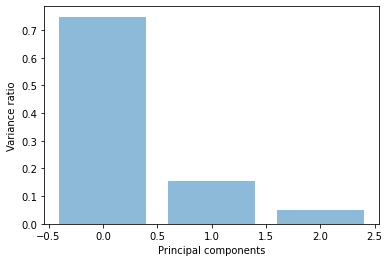

array([0.74791825, 0.15334176, 0.04882536], dtype=float32)

In [50]:
n_comp = calc_pc_n(extract_pc(dorsal_train),pc_thresh) #determine number of PCs in train_data using threshold
pca = extract_pc(dorsal_train, n_comp) #conduct PCA one more time with that number of PCs
pca.explained_variance_ratio_


In [28]:
print(pca.explained_variance_ratio_)


[0.7479177  0.15334198]


In [171]:
"""
extract voxel responses from seed
instead of concatenating the filtered_func, append the concat the voxels TS
store each TS in a list, then iterateively create train and test sets by concating different runs
"""

seed_ts =[]
all_funcs = []

ventral_rois = ['LO_toolloc', 'PFS_toolloc']
dorsal_rois = ['PPC_spaceloc', 'APC_spaceloc', 'PPC_depthloc', 'APC_depthloc', 'PPC_toolloc', 'APC_toolloc', 'PPC_distloc', 'APC_distloc']]

for run in runs:
    #load filtered_func and roi and convert to np
    curr_run = image.load_img(f'{exp_dir}/run-0{run}/1stLevel.feat/filtered_func_data_reg.nii.gz')
    affine = curr_run.affine
    curr_run = image.get_data(curr_run)
    roi = image.get_data(image.load_img(f'{roi_dir}/{lr}{rr}_peak.nii.gz'))

    

    #reshape roi and mask the current run
    reshaped_roi = np.reshape(roi, (91,109,91,1))
    masked_img = reshaped_roi*curr_run

    #extract voxel resposnes from within mask
    vox_acts = masked_img.reshape(-1, 331) #reshape into rows (voxels) x columns (time)
    vox_acts =vox_acts[~np.all(vox_acts == 0, axis=1)] #remove voxels that are 0 (masked out)
    vox_acts = np.transpose(vox_acts)
    vox_acts = vox_acts[first_fix:, :] #remove first 8 vols

    seed_ts.append(vox_acts)

#the first index is the position in the list
all_ts = np.array(all_ts)

       



In [172]:
all_ts[0].shape

(323, 8)

In [173]:
#train/test split in 6 and 2 runs
rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)

#extract data for each split
for train_index, test_index in rs.split(runs):
    train_runs = all_ts[train_index]
    test_runs = all_ts[test_index]

    train_data = np.concatenate((train_runs), axis = 0)
    test_data = np.concatenate((test_runs), axis = 0)
    
    n_comp = calc_pc_n(extract_pc(train_data),pc_thresh) #determine number of PCs in train_data using threshold
    pca = extract_pc(train_data, n_comp) #conduct PCA one more time with that number of PCs

    #
    train_seed = pca.transform(train_data) #transform train data in PCs
    test_seed = pca.transform(test_data) #transform test data into PCs

    #
    



train [1 7 3 0 5 4] test [6 2]
train [3 7 0 4 2 5] test [1 6]


In [193]:
roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')
curr_coords = roi_coords[(roi_coords['index'] == 0) & (roi_coords['task'] =="spaceloc") & (roi_coords['roi'] ==f'rPPC')]
coords = tuple(curr_coords[['x','y','z']].values.tolist()[0])
roi_masker = input_data.NiftiSpheresMasker(coords, radius = 6)

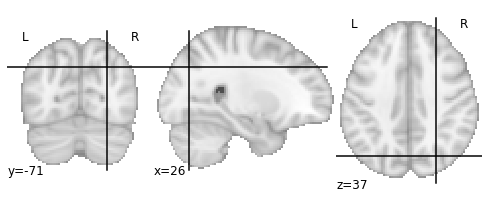

In [194]:
plotting.plot_roi(roi_masker., cut_coords=coords)

In [189]:
f'{lr}{rr}'

'rPPC_spaceloc'

In [ ]:
#do PCA on voxel responses


    
n_comp = calc_pc_n(extract_pc(vox_acts),.9)
pca2 = extract_pc(vox_acts, n_comp)
model_pcs = pca2.transform(vox_acts)

In [138]:
vox_acts = vox_acts[10:, :]
vox_acts.shape

(321, 8)

In [134]:
model_pcs.shape

(331, 3)

0 0.9992427 0.9992427229881287


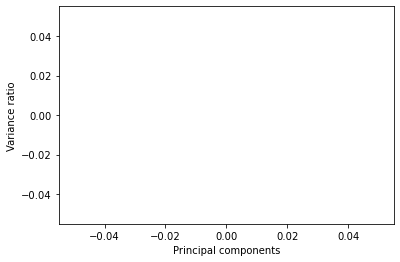

In [115]:
explained_variance = pca2.explained_variance_ratio_
thresh = .95
    
var = 0
for n_comp, ev in enumerate(explained_variance):
    var += ev #add each PC's variance to current variance
    print(n_comp, ev, var)

    if var >=thresh: #once variance > than thresh, stop
        break


plt.bar(range(len(explained_variance[0:n_comp])), explained_variance[0:n_comp], alpha=0.5, align='center')
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [116]:
explained_variance[0]

0.9992427

In [77]:
test.shape

(425, 331)

In [78]:
test[0:20,:]

array([[11566.57  , 11544.778 , 11567.158 , ..., 11574.125 , 11522.791 ,
        11607.864 ],
       [10523.8125, 10368.75  , 10499.355 , ..., 10608.061 , 10523.553 ,
        10554.417 ],
       [10637.129 , 10556.656 , 10567.902 , ..., 10605.409 , 10582.474 ,
        10675.892 ],
       ...,
       [11086.221 , 11025.509 , 11049.294 , ..., 11069.007 , 11092.27  ,
        11037.554 ],
       [11105.062 , 10987.007 , 11027.2295, ..., 11019.044 , 10983.327 ,
        10975.02  ],
       [10780.583 , 10717.418 , 10742.406 , ..., 10717.839 , 10682.2   ,
        10669.751 ]], dtype=float32)